In [36]:
import torch
import torch.nn as nn 
from torchvision import  datasets, models, transforms
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader
import numpy as np 
import time
import matplotlib.pyplot as plt 
from PIL import Image
import os 
from collections import Counter
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve,  auc
from sklearn.preprocessing import label_binarize


In [37]:
transform = transforms.Compose([
    
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(10), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #* these  values i use for grayscale since the chest x rays is 
])

In [38]:
data_dir = './Datasets/LungXRays-grayscale'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)
print(f'training data: {len(train_dataset)}')
print(f'validation data: {len(val_dataset)}')
print(f'test data: {len(test_dataset)}')

training data: 4861
validation data: 1620
test data: 1625


In [39]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True); 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataiter = iter(train_loader)
imgs, labels = next(dataiter)
print(imgs.shape)
print(torch.min(imgs), torch.max(imgs))
print(f'images shapes: {imgs.shape}')

torch.Size([32, 3, 224, 224])
tensor(-2.1179) tensor(2.6400)
images shapes: torch.Size([32, 3, 224, 224])


In [40]:
num_classes = len(train_dataset.classes)
restNet18_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
restNet18_model.fc = nn.Linear(restNet18_model.fc.in_features, num_classes)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


In [41]:
restNet18_model.load_state_dict(torch.load('best_resNet18.pth', map_location=device, weights_only=True))
model = restNet18_model.to(device)


In [42]:
def evaluation(model, test_loader, criterion, device):
    test_loss = 0.0
    all_pred = []
    all_labels = []
    all_probs = []   
    correct = 0
    total = 0
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
       
            _, predicted = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            
            all_pred.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
  
    result_test_loss = test_loss / len(test_loader)
    result_test_acc = 100 * correct / total
    
     
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs) 
    num_classes = all_probs.shape[1]
    y_true = label_binarize(all_labels, classes=range(num_classes))
    auc = roc_auc_score(y_true, all_probs, multi_class='ovr', average='macro')
    
    
    return result_test_loss, result_test_acc, all_pred, all_labels, auc, all_probs

In [43]:
criterion = nn.CrossEntropyLoss(); 

In [44]:
test_loss, test_acc, all_preds, all_labels, auc, all_probs= evaluation(model, test_loader, criterion, device)
print(f'Test Accuaracy: {test_acc:.2f}% AUC: {auc:.4f}')

Test Accuaracy: 97.85% AUC: 0.9993


Accuracy: 97.85

 classification Report
              precision    recall  f1-score   support

     COVID19     0.9828    0.9828    0.9828       407
      Normal     0.9629    0.9749    0.9689       399
   Pneumonia     0.9779    0.9684    0.9731       411
Tuberculosis     0.9902    0.9877    0.9890       408

    accuracy                         0.9785      1625
   macro avg     0.9784    0.9785    0.9784      1625
weighted avg     0.9785    0.9785    0.9785      1625



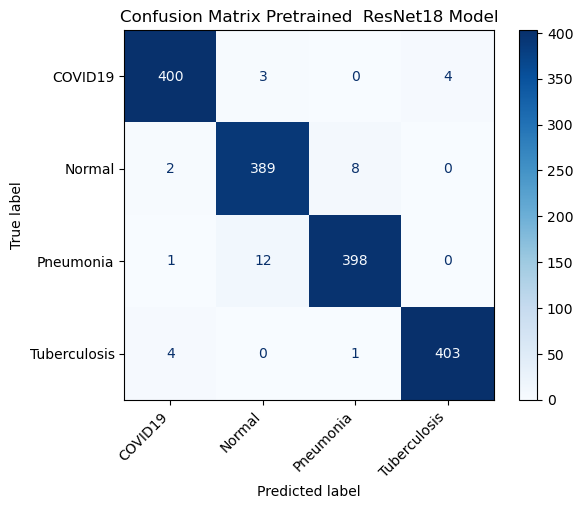

In [45]:
accuracy = accuracy_score(all_preds, all_labels)
print(f"Accuracy: {100*accuracy:.2f}")
print('\n classification Report')
cls_report = classification_report(all_preds, all_labels, target_names=train_dataset.classes, digits=4)
print(cls_report)

cm = confusion_matrix(all_preds, all_labels)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
display.plot(cmap='Blues' )


plt.xticks(rotation = 45, ha= 'right')
plt.title('Confusion Matrix Pretrained  ResNet18 Model')
plt.show()

In [53]:
def plot_roc_curve(all_labels, all_probs, num_classes, class_names):
    
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    
    y_true = label_binarize(all_labels, classes=range(num_classes))
    all_probs = np.array(all_probs)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

 
    plt.figure(figsize=(4, 4))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve for ResNet18')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


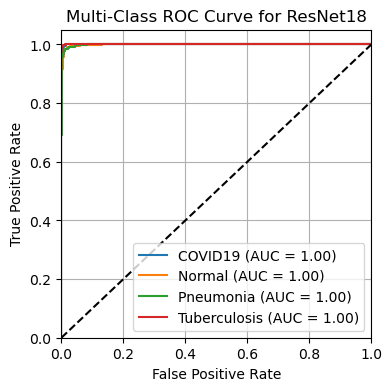

In [ ]:
num_classes = len(train_dataset.classes)
class_names = train_dataset.classes  
plot_roc_curve(all_labels, all_probs, num_classes, class_names)